# Result comparaison for Superpixels Entropy

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC
from classes import MinHeap

import SSGA

145 145 200


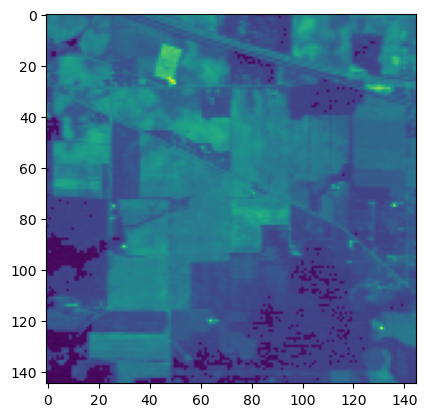

In [2]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter


N,M,B = usedDataset["shape"]
trainData = usedDataset["data"]
print(N,M,B)

def crop_img(size):
    size = min(size, N, M)
    if size!=N and size!=M:
        xStart = np.random.randint(0, N-1-size)
        yStart = np.random.randint(0, M-1-size)
        trainData = usedDataset["data"][xStart:xStart+size, yStart:yStart+size, :]
        trainData = Data.standardize_data(trainData)
        N,M,B = trainData.shape
    return trainData
#trainData = crop_img(400)

b = np.random.randint(0, B-1)
plt.imshow(trainData[:,:,b])
plt.show()

## Compute SPs

In [3]:
RunDataFormat = False
useLambdasModel = True

import json
datasetFolder = "datasets/"
saved_file_name = {
    True: "FormatDataSuperpixels",
    False: "SimFunSuperpixels"
}

complete_save_file_name = datasetFolder + saved_file_name[RunDataFormat]
if useLambdasModel and not RunDataFormat:
    complete_save_file_name += "UsedLambdasModel"
complete_save_file_name +=  usedDataset["name"] +".json"
print(complete_save_file_name)

datasets/SimFunSuperpixelsUsedLambdasModelIndian Pines.json


In [4]:
if RunDataFormat:
    data1 = usedDataset["data"].copy()
    data2 = Data.normalized_data(usedDataset["data"].copy())
    data3 = Data.standardize_data( usedDataset["data"].copy() )
    datas = [data1, data2, data3]
    names = ["Basic", "Normalized", "Standardized"]
else:
    datas = [ERS.complete_basic_similarity,
                        ERS.complete_norm2_similarity,
                        ERS.complete_norm1_similarity]
    names = ["Basic", "(.)²", "|.|"]
    trainData = Data.standardize_data(usedDataset["data"])
    getLambdas = [LC.getLambdaAverage, LC.getLambdaNorm2, LC.getLambdaNorm1]


FoundLambdaCoeffKey = "DataFormat" if RunDataFormat else "SimilarityFunction"
LambdaCoeffs = Data.FoundLambdaCoeff[FoundLambdaCoeffKey]
Ks = [300, 1100, 1300]
#Ks = list(LambdaCoeffs[usedDataset["name"]].keys())
if len(Ks)==1:
    complete_save_file_name = complete_save_file_name[:len(complete_save_file_name)-5] + str(Ks[0]) + "SP.json"
    print(complete_save_file_name)
Ks.sort(key=lambda x:x)

In [ ]:
def compute_SPs(Ks, save_data=False, find_lambda=True):
    SPsDic = {}
    for K in Ks:
        print("K:", K)
        Ps = LC.computePs(K, N, M)

        current_list = []
        for i,data in enumerate(datas):
            print(i, end=" ")
            if RunDataFormat:
                if find_lambda:
                    SPs, coeff = LC.dichotomies_search(data, K, 1, 400, ERS.complete_basic_similarity, Ps)
                    print("Choosen Coef:", coeff)
                else:
                    SPs = ERS.find_superpixel(data, K, LambdaCoeffs[usedDataset["name"]][K][i], ERS.complete_basic_similarity, True)
            else:
                if useLambdasModel:
                    SPs = ERS.find_superpixel(trainData, K, int(getLambdas[i](K,N,M)), data, True)
                else:
                    if find_lambda:
                        SPs, coeff = LC.dichotomies_search(trainData, K, 1, 500, data, Ps)
                        print("Choosen Coef:", coeff)
                    else:
                        SPs = ERS.find_superpixel(trainData, K, LambdaCoeffs[usedDataset["name"]][K][i], data, True)
            current_list.append(SPs)
        print()
        SPsDic[K] = current_list


    if save_data:
        json_object = json.dumps(SPsDic)
        with open(complete_save_file_name, "w") as f :
            f.write(json_object)
            f.close()
    return SPsDic


SPsDic = compute_SPs(Ks, save_data=True, find_lambda=False)

K: 300
0 1 2 
K: 1100
0 1 2 
K: 1300
0 1 2 


In [5]:
with open(complete_save_file_name, "r") as f:
    tempDic = json.load(f)
    f.close()
SPsDic = {}
for key, dataListe in tempDic.items():
    SPsDic[int(key)] = [[[tuple(coor) for coor in SP] for SP in SPsListe] for SPsListe in dataListe]

Ks = list(SPsDic.keys())
Ks.sort()

### Superpixels Classifier

In [6]:
class Superpixel:
    def __init__(self, liste, labels, gt, counting0=True):
        self.labels = [l for l in labels if not(not counting0 and l==0)]
        self.pixels = [coor for coor in liste if not(not counting0 and gt[coor]==0)]

        self.class_count = {l:0 for l in self.labels}
        for coor in self.pixels:
            self.class_count[gt[coor]] += 1

        self.guess = self.labels[0]
        for l in self.labels:
            if self.class_count[l] > self.class_count[self.guess]:
                self.guess = l

        self.proportion = self.class_count[self.guess]/len(self.pixels)
        self.isSingleClass = self.class_count[self.guess] == len(self.pixels)




class SuperpixelClassifier:
    def __init__(self, liste, labels, gt, counting0=True):
        self.counting0 = counting0
        self.labels = [l for l in labels if not(not counting0 and l==0)]

        self.liste = []
        self.pixels = []
        for l in liste:
            new_list = [coor for coor in l if not(not counting0 and gt[coor]==0)]
            if new_list!=[]:
                self.liste.append(new_list)
                self.pixels += new_list

        self.SPs:list[Superpixel] = [Superpixel(l, self.labels, gt, counting0) for l in self.liste]
        self.association:dict[tuple[int,int], Superpixel] = {}
        for i,SP in enumerate(self.SPs):
            for coor in SP.pixels:
                self.association[coor] = i

        self.data_class = {l:[] for l in labels}
        self.guess_map = np.zeros(gt.shape, dtype=int)
        for x,y in self.pixels:
            g = self.guess(x,y)
            self.guess_map[x,y] = g
            self.data_class[g].append((x,y))

    
    def getSP(self, x,y) -> Superpixel:
        return self.SPs[self.association[(x,y)]]
    

    def guess(self, x,y):
        return self.getSP(x,y).guess


    def predict(self, liste):
        return [self.guess(x,y) for x,y in liste]
    
    
    def accuracy(self, samples, labels):
        assert len(samples)==len(labels)
        prediction = self.predict(samples)
        return len([i for i in range(len(samples)) if prediction[i]==labels[i]])
    

    def singleClassCount(self):
        return len([i for i in range(len(self.SPs)) if self.SPs[i].isSingleClass])
    
    def singleClassProportion(self):
        return self.singleClassCount()/len(self.SPs)
    

    def averageProportion(self):
        return np.average([SP.proportion for SP in self.SPs])

    
    def labelAccuracy(self, data_class, label):
        if label not in self.labels:
            return False
        goodGuessCount = 0
        for x,y in data_class[label][1]:
            if self.guess_map[x,y] == label:
                goodGuessCount += 1
        return goodGuessCount/len(data_class[label][1])
    
    def overallAccuracy(self, gt):
        goodGuessCount = 0
        for x,y in self.pixels:
            if gt[x,y] == self.guess_map[x,y]:
                goodGuessCount +=1
        return goodGuessCount/len(self.pixels)
    

    def averageAccuracy(self, gt):
        dic = {l:[0,0] for l in self.labels}
        for x,y in self.pixels:
            l = gt[x,y]
            dic[l][0] += 1
            if l==self.guess(x,y):
                dic[l][1] += 1
        
        return sum([e[1]/e[0] for e in dic.values()])/len(self.labels)
    


    def jaccard(self, gt, data_class, label, returnWeight=False):
        liste = data_class[label][1]
        if not self.counting0:
            liste = [coor for coor in liste if gt[coor]!=0]
            
        self_set = set(self.data_class[label])
        data_set = set(liste)
        inter = len(data_set.intersection(self_set))
        union = len(data_set.union(self_set))

        if returnWeight:
            return inter/union, len(liste)
        return inter/union
    
    
    def averageWeightedJaccard(self, gt, data_class):
        sum = 0
        for l in self.labels:
            jacc, weight = self.jaccard(gt, data_class, l, returnWeight=True)
            sum += weight*jacc
        return sum/len(self.labels)


In [7]:
def SP_average(data, SP):
    N,M,B = data.shape
    res = np.zeros(B)
    for x,y in SP:
        res += data[x,y,:]
    return res


def norm1(x,y):
    return np.abs(x-y).sum()/len(x)

def norm2(x,y):
    return ((x-y)**2).sum()/len(x)


def merge_SPs_basic(data, SPs, L, simFun=norm1):
    nb_SPs = len(SPs)
    existing = [True for _ in range(nb_SPs)]
    SPs_liste = [[SP, SP_average(data, SP)] for SP in SPs]
    weights = [{j:simFun(SPs_liste[i][1], SPs_liste[j][1]) for j in range(i+1, nb_SPs)} for i in range(nb_SPs)]

    while nb_SPs>L:
        minimun = None
        argmin = None
        for k1 in range(len(SPs)):
            if existing[k1]:
                for k2 in weights[k1].keys():
                    if existing[k2]:
                        if minimun==None or weights[k1][k2]<minimun:
                            argmin = (k1, k2)
                            minimun = weights[k1][k2]
        k1,k2 = argmin
        SP_union = SPs_liste[k1][0] + SPs_liste[k2][0]
        SPs_liste[k1] = [SP_union, SP_average(data, SP_union)] #Opti to compute average easy without dividing by len(SP)
        existing[k2] = False

        for k in range(k1+1, len(SPs)):
            if existing[k]:
                weights[k1][k] = simFun(SPs_liste[k1][1], SPs_liste[k][1])
        for k in range(k1):
            if existing[k]:
                weights[k][k1] = simFun(SPs_liste[k1][1], SPs_liste[k][1])
        nb_SPs -= 1
    
    return [SPs_liste[i][0] for i in range(len(SPs)) if existing[i]]
       
        
from sklearn.cluster import KMeans
def merge_SPs_kmeans(data, SPs, L):
    nb_cluster = L
    kmeans = KMeans(n_clusters=nb_cluster, n_init="auto")
    features = [SP_average(data, SP) for SP in SPs]
    kmeans.fit(features)

    SPs_merged = [[] for _ in range(nb_cluster)]
    for i in range(len(kmeans.labels_)):
        SPs_merged[kmeans.labels_[i]] += SPs[i]
    return SPs_merged



from sklearn.cluster import AgglomerativeClustering
def merge_Sps_agglomerative(data, SPs, L):
    features = [SP_average(data, SP) for SP in SPs]
    clustering = AgglomerativeClustering(n_clusters=L, linkage='ward')
    labels = clustering.fit_predict(features)

    SPs_merged = [[] for _ in range(L)]
    for i in range(len(labels)):
        SPs_merged[labels[i]] += SPs[i]
    return SPs_merged


from sklearn.cluster import SpectralClustering
def merge_Sps_spectral(data, SPs, L):
    features = [SP_average(data, SP) for SP in SPs]
    clustering = SpectralClustering(n_clusters=L, affinity='nearest_neighbors', assign_labels='kmeans')
    labels = clustering.fit_predict(features)

    SPs_merged = [[] for _ in range(L)]
    for i in range(len(labels)):
        SPs_merged[labels[i]] += SPs[i]
    return SPs_merged


In [14]:
dataForMerges = Data.standardize_data(usedDataset["data"])

K = 300
take_0_into_account = False
if take_0_into_account:
    SPs = SPsDic[K][2]
else:
    SPs = [SP.pixels for SP in ClassifierDic[False][K][2].SPs]


print(len(usedDataset["labels"]))
#SPs_merged = merge_SPs(usedDataset["data"], SPs, 20, simFun=norm2)

L = 17
liste_SPs = [SPs,
             merge_SPs_basic(dataForMerges, SPs, L),
             merge_SPs_kmeans(dataForMerges, SPs, L),
             merge_Sps_agglomerative(dataForMerges, SPs, L),
             merge_Sps_spectral(dataForMerges, SPs, L)]
merged_SPs_names = ["without", "basic", "kmeans", "agglomerative", "SpectralClustering"]

17


198
[53, 49, 47, 87, 50, 69, 21, 63, 1, 47, 45, 78, 49, 28, 38, 45, 63, 48, 18, 29, 70, 48, 35, 55, 48, 65, 76, 46, 46, 44, 67, 78, 47, 46, 85, 63, 1, 82, 14, 23, 15, 12, 14, 66, 58, 20, 1, 46, 28, 29, 63, 93, 74, 2, 63, 55, 54, 32, 75, 65, 39, 77, 75, 48, 18, 8, 48, 84, 39, 92, 49, 39, 57, 62, 76, 55, 59, 32, 86, 68, 55, 76, 56, 58, 85, 89, 28, 34, 74, 82, 52, 66, 12, 36, 77, 51, 48, 49, 58, 42, 62, 60, 70, 88, 33, 49, 62, 91, 65, 62, 44, 67, 33, 11, 44, 68, 34, 35, 1, 31, 60, 26, 101, 43, 63, 49, 64, 84, 51, 44, 63, 69, 40, 80, 63, 82, 1, 58, 62, 98, 40, 19, 38, 56, 112, 83, 14, 53, 30, 108, 51, 56, 79, 45, 79, 73, 64, 99, 53, 39, 59, 40, 3, 64, 38, 17, 24, 17, 67, 62, 31, 56, 3, 76, 26, 58, 54, 66, 35, 43, 33, 24, 56, 60, 65, 71, 99, 8, 50, 50, 62, 32, 59, 59, 45, 59, 60, 45]


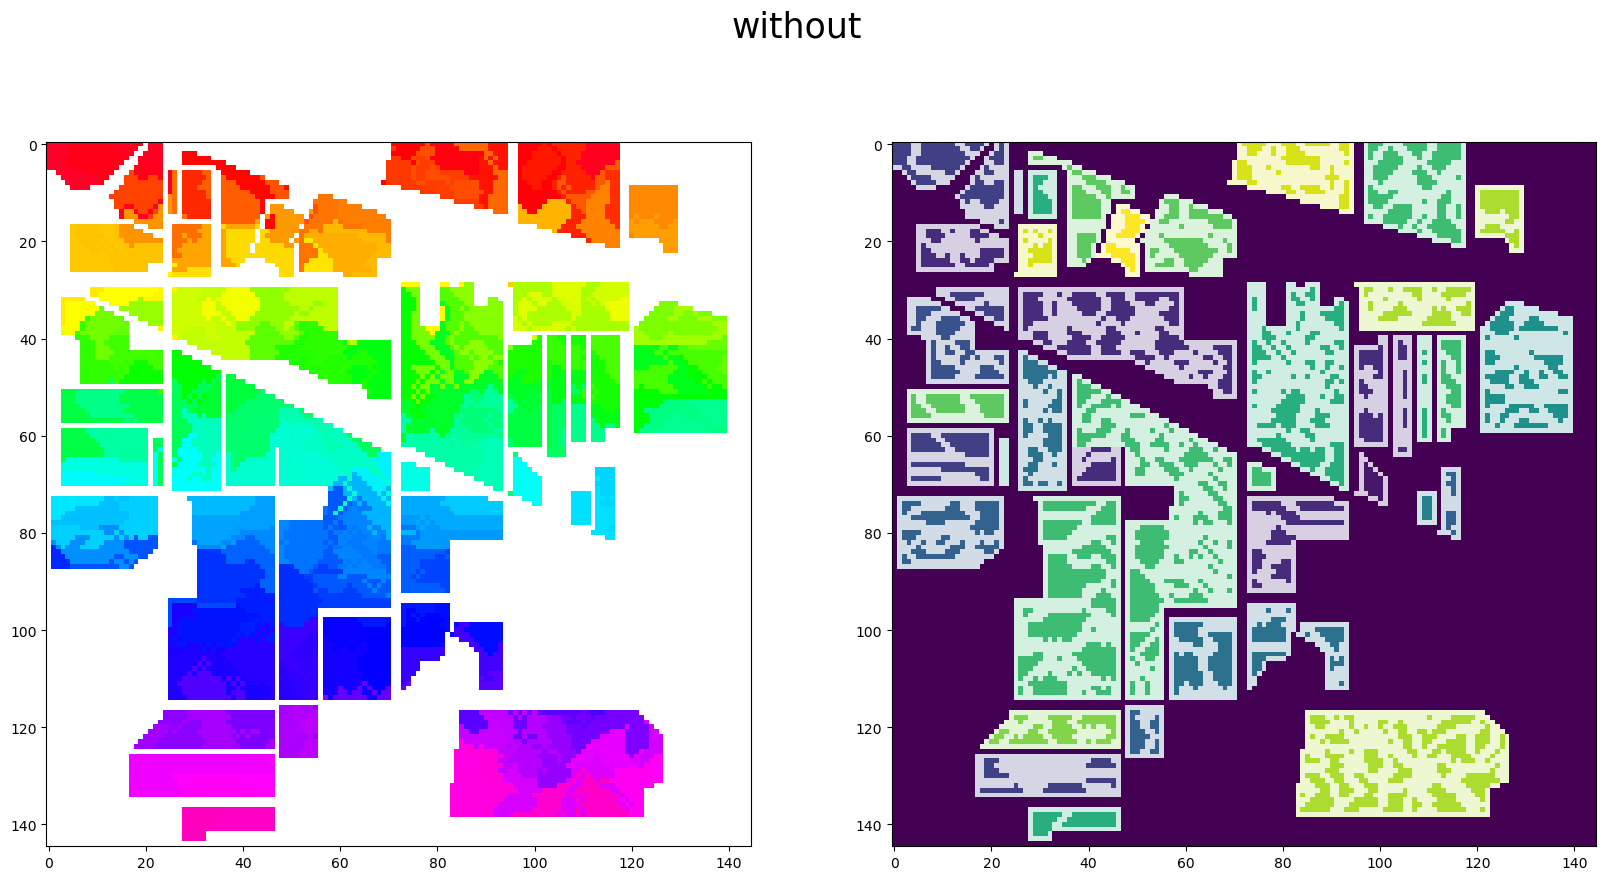

17
[775, 305, 348, 1049, 489, 601, 1035, 797, 711, 694, 204, 304, 478, 600, 1050, 319, 490]


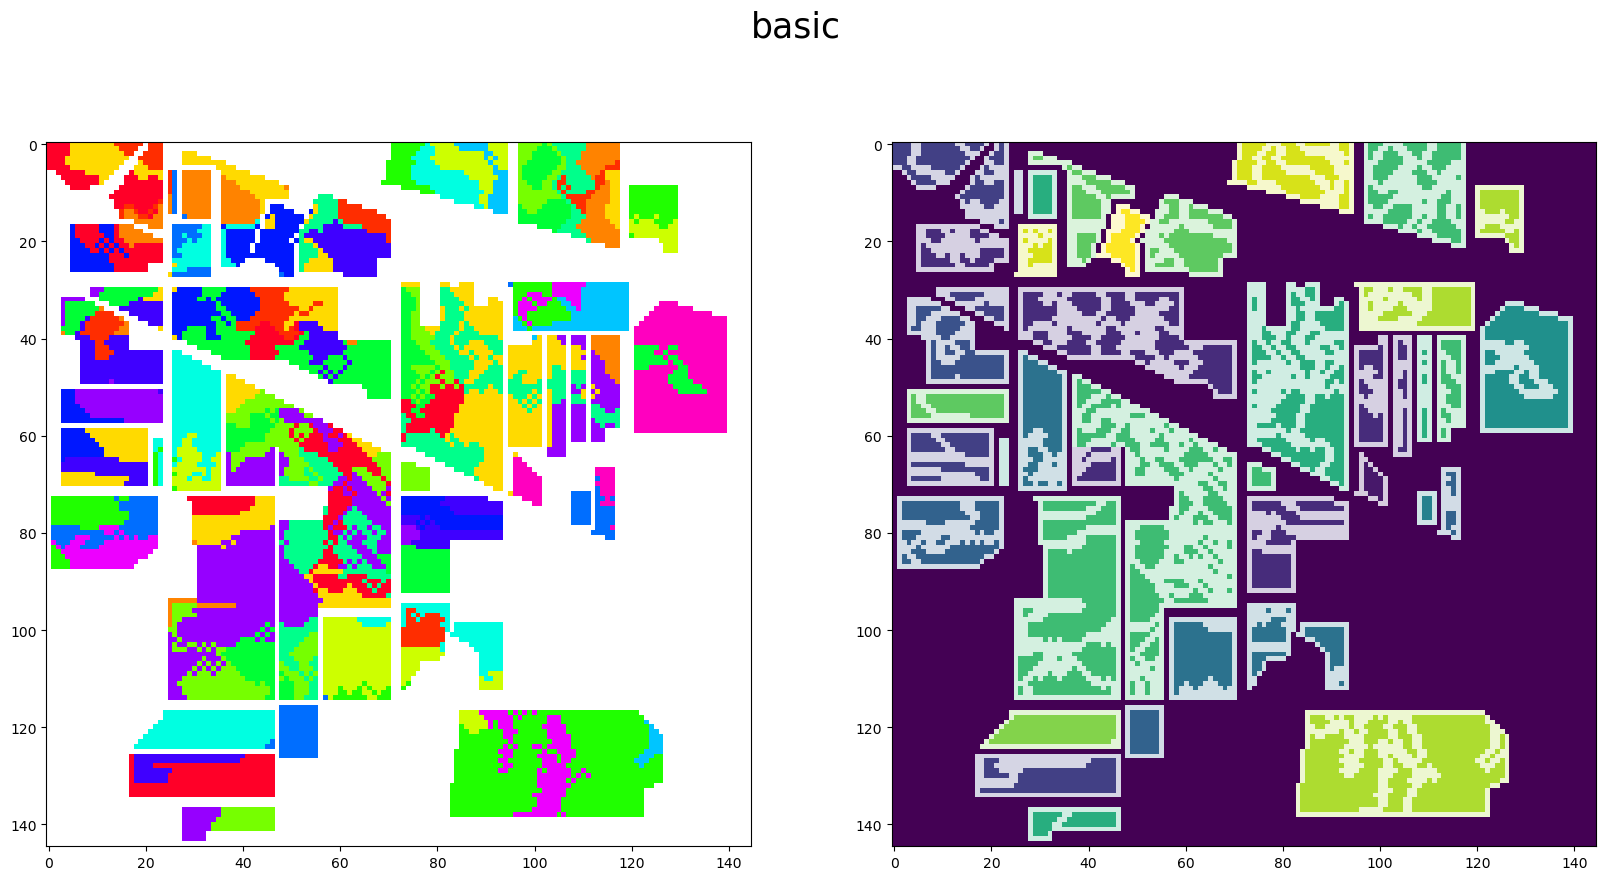

17
[927, 821, 463, 688, 641, 1272, 579, 504, 236, 435, 400, 444, 313, 488, 1111, 429, 498]


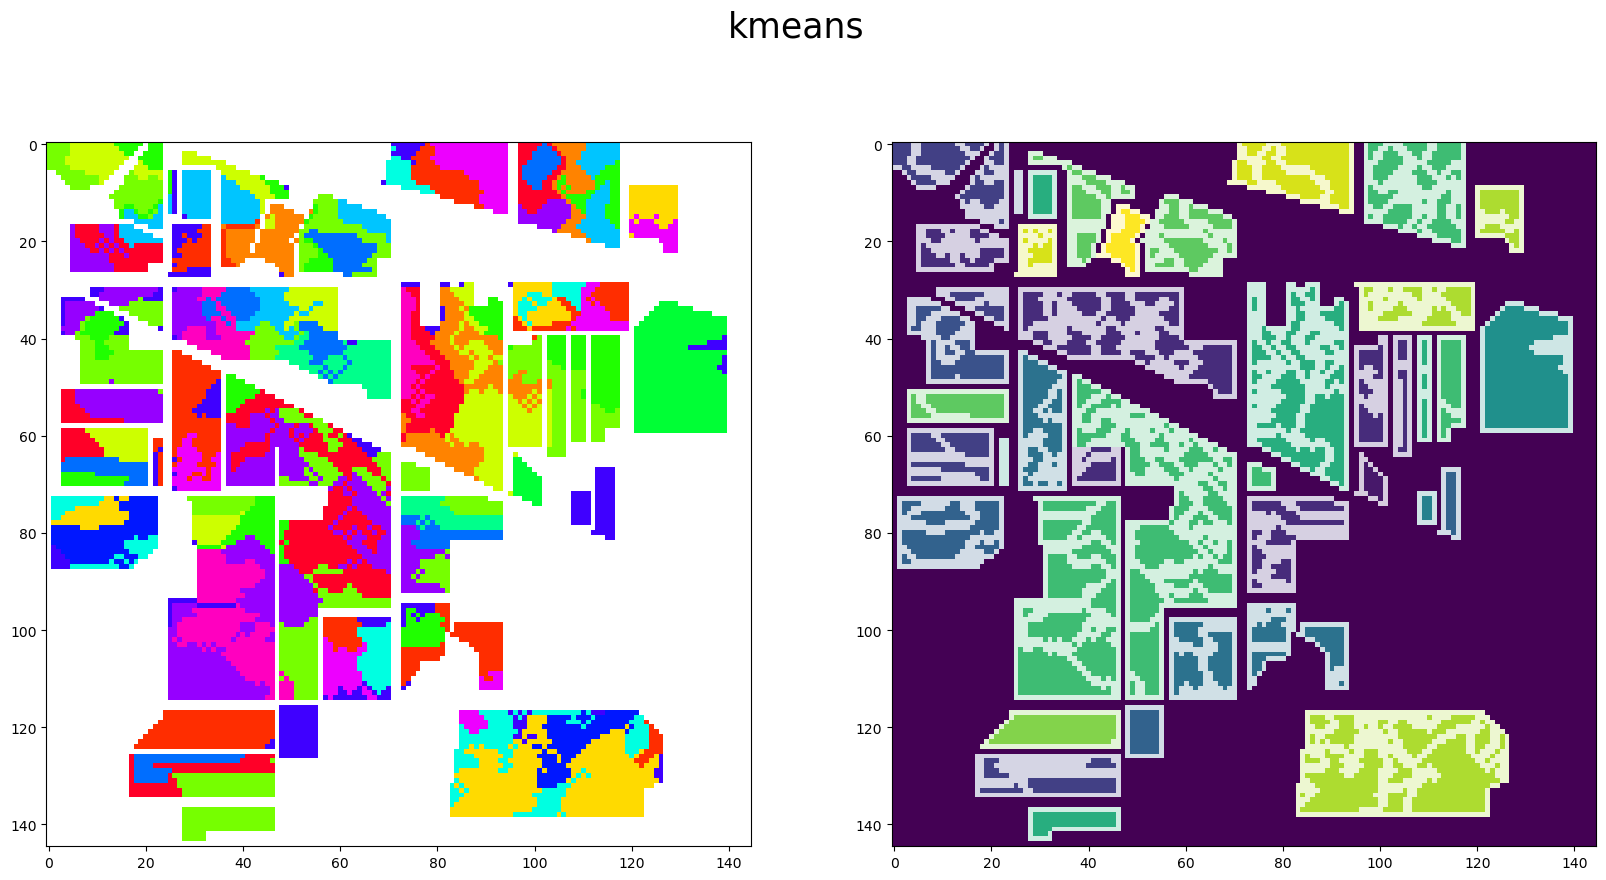

17
[981, 671, 577, 1602, 344, 373, 710, 247, 1037, 658, 313, 973, 688, 380, 385, 128, 182]


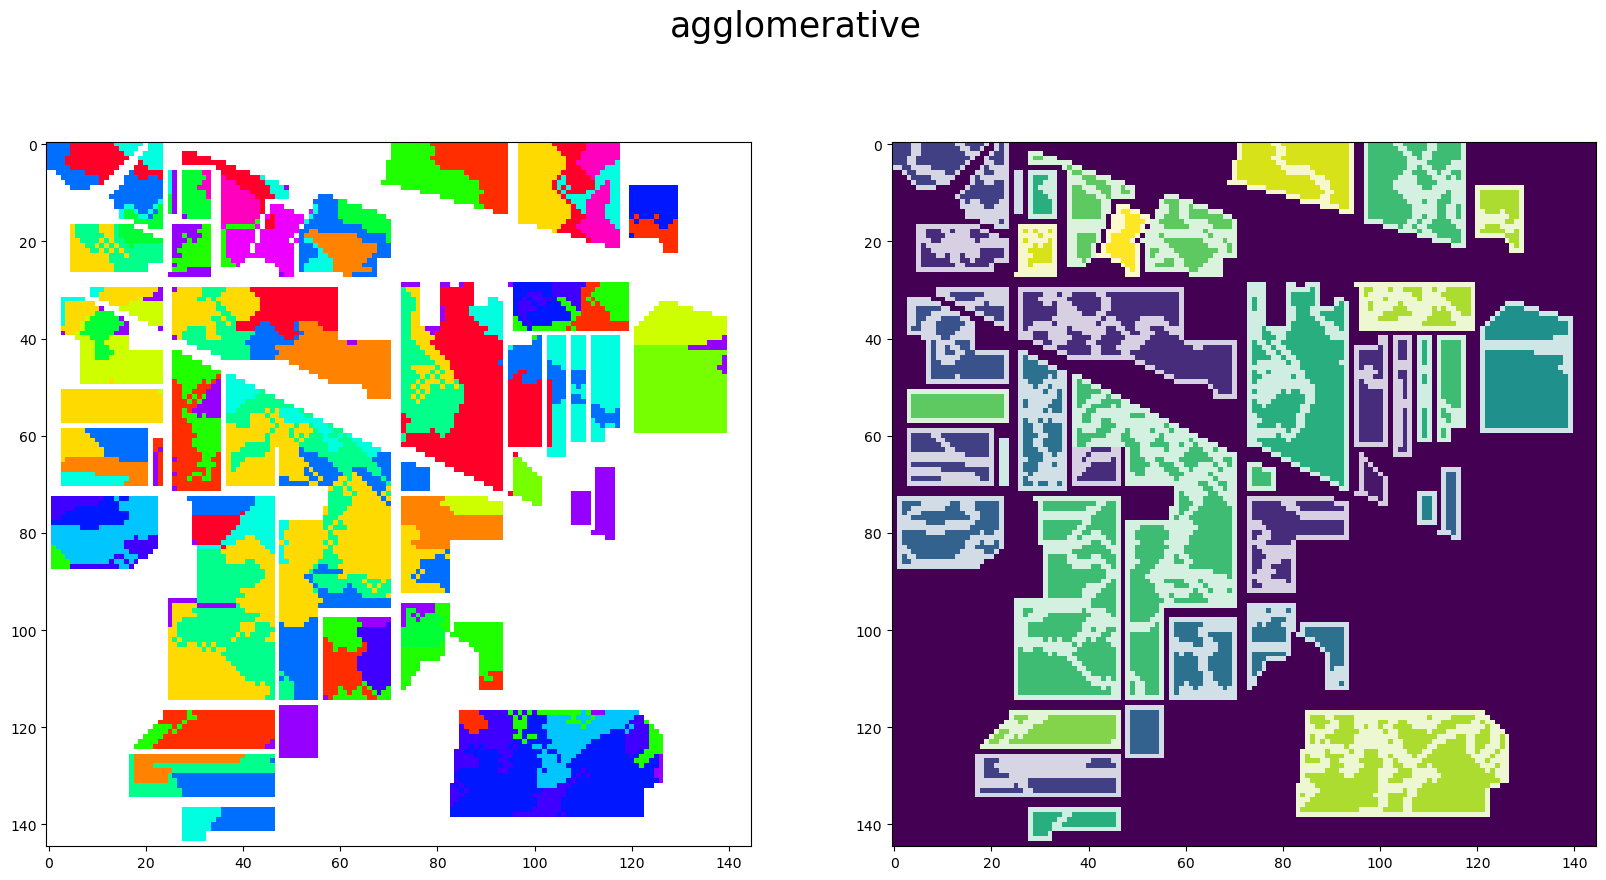

17
[433, 552, 769, 621, 1037, 605, 622, 608, 380, 396, 1001, 786, 933, 153, 193, 267, 893]


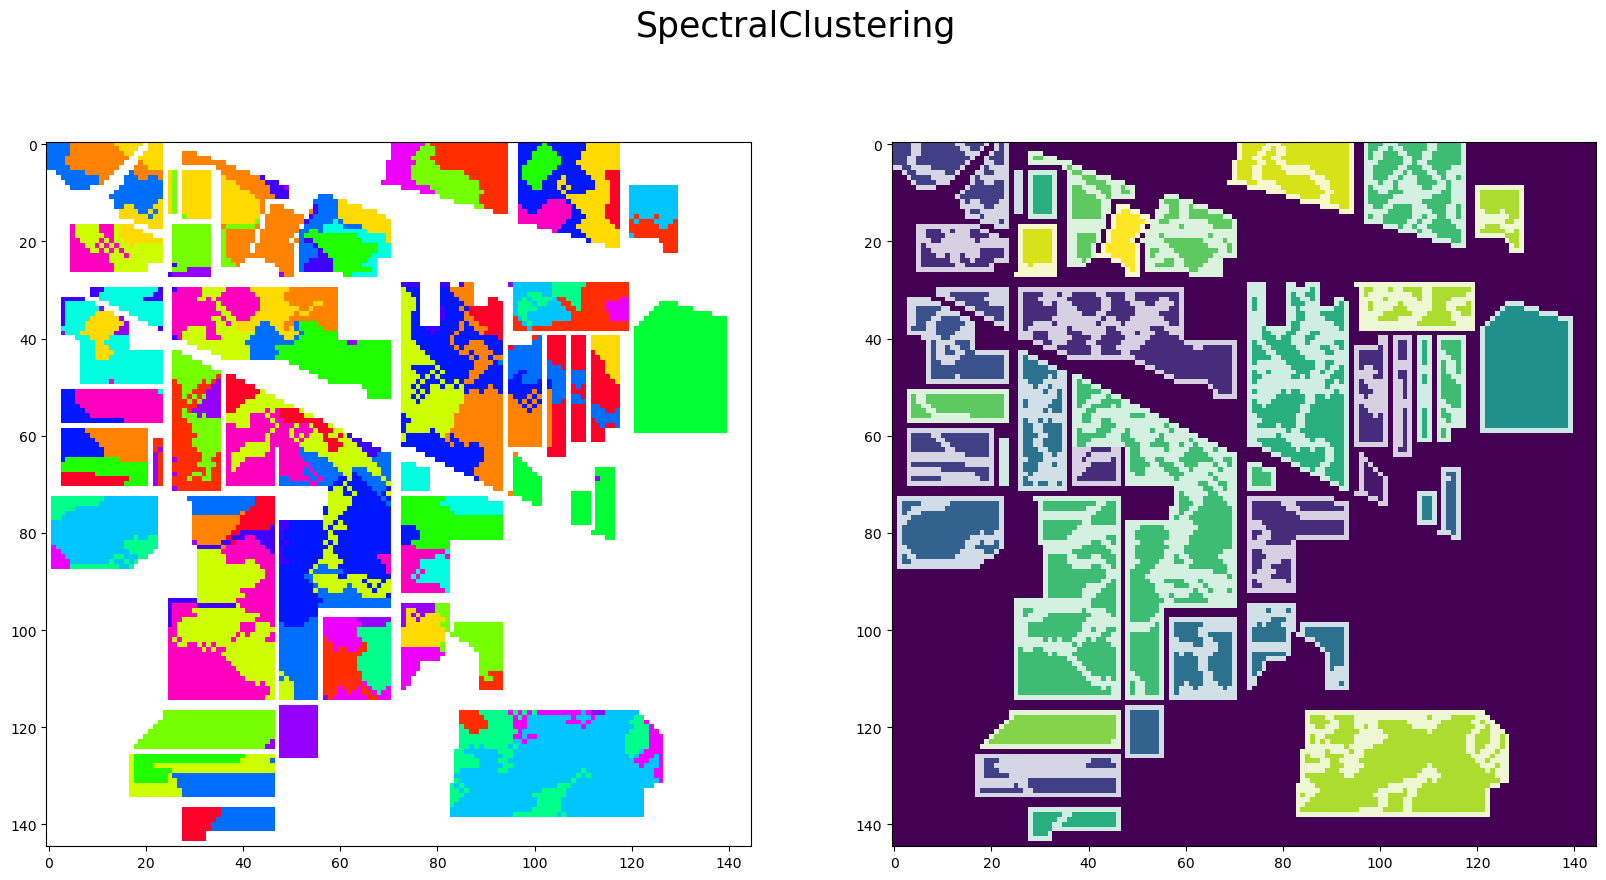

In [15]:
for i,SPs in enumerate(liste_SPs):
    print(len(SPs))
    print([len(SP) for SP in SPs])

    fig, axs = plt.subplots(1, 2, figsize=(20,10))
    cmap = mpl.colormaps["gist_rainbow"]
    colors = cmap(np.linspace(0, 1, len(SPs)))
    #np.random.shuffle(colors)
    n,m,_ = usedDataset["data"].shape
    img = np.zeros((n,m,len(colors[0])))
    for j,SP in enumerate(SPs):
        for x,y in SP:
            img[x,y] = colors[j]

    axs[0].imshow(img)

    axs[1].imshow(usedDataset["gt"])
    mask = ERS.create_overlay_borders(usedDataset["gt"], SPs, color=[255,255,255,200])
    axs[1].imshow(mask)

    fig.suptitle(merged_SPs_names[i], fontsize=25)
    plt.show()

In [8]:
doMergeSPs = False

if doMergeSPs:
    SPsDic2 = {K:[merge_SPs(usedDataset["data"], SPsDic[K][i], len(usedDataset["labels"]))
                 for i in range(len(datas))] for K in Ks}


ClassifierDic:dict[int, list[SuperpixelClassifier]] = {}
for b in [True, False]:
    ClassifierDic[b] = {}
    for K in Ks:
        ClassifierDic[b][K] = [
            SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
                    for SPs in SPsDic[K]
            ]

### Visual result

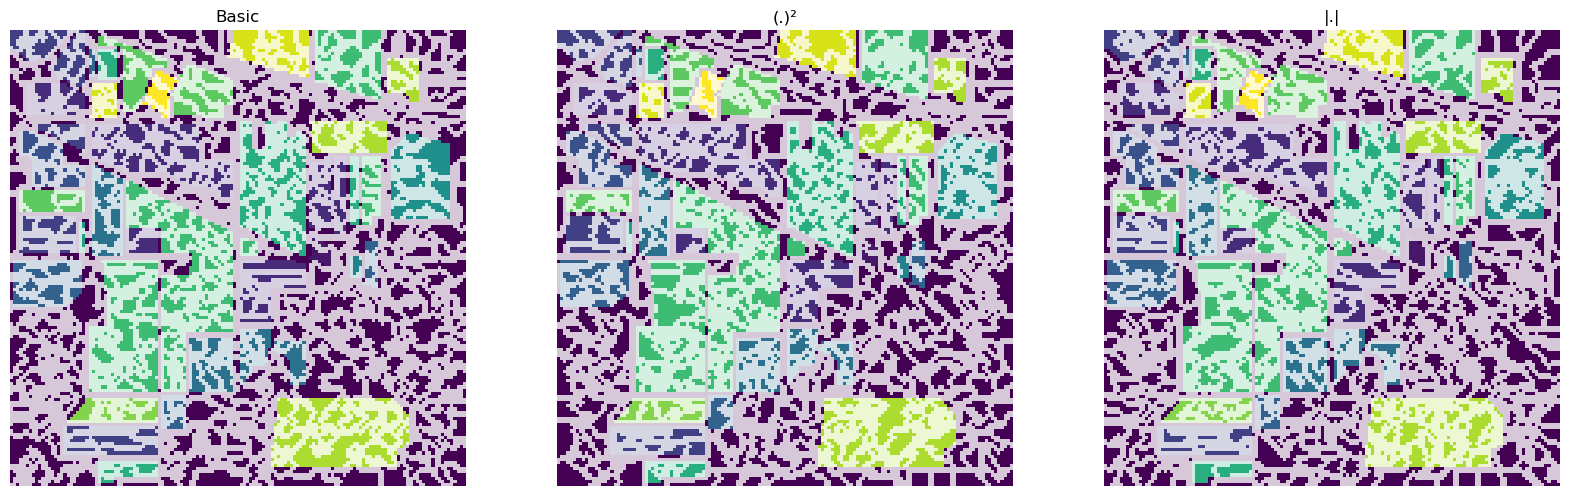

True


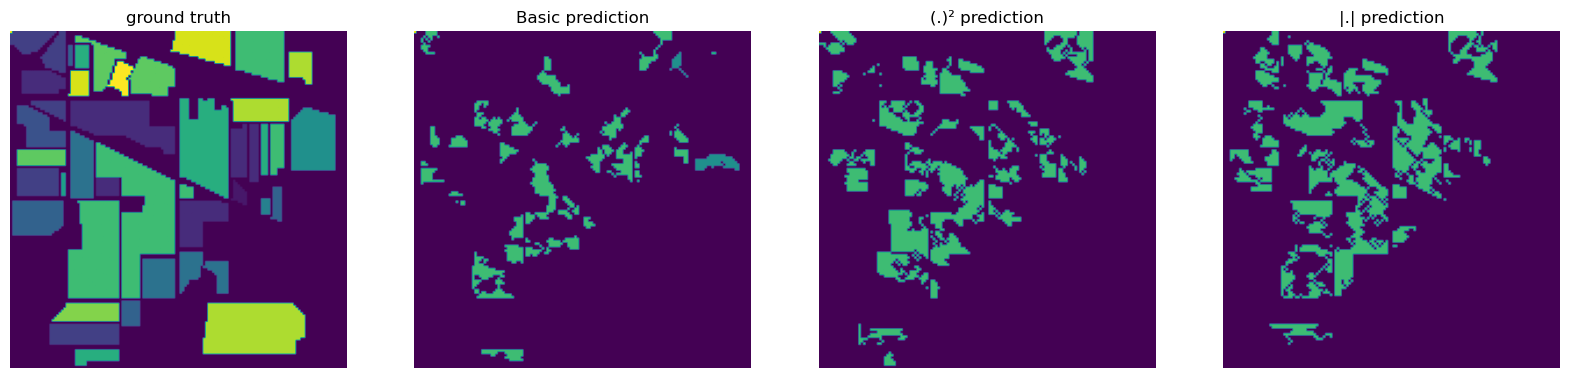

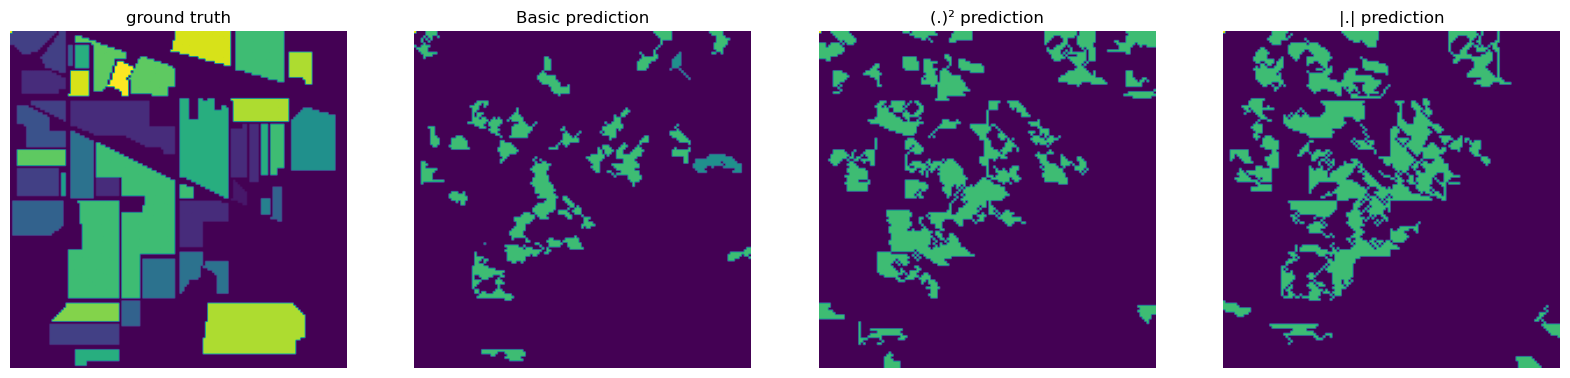

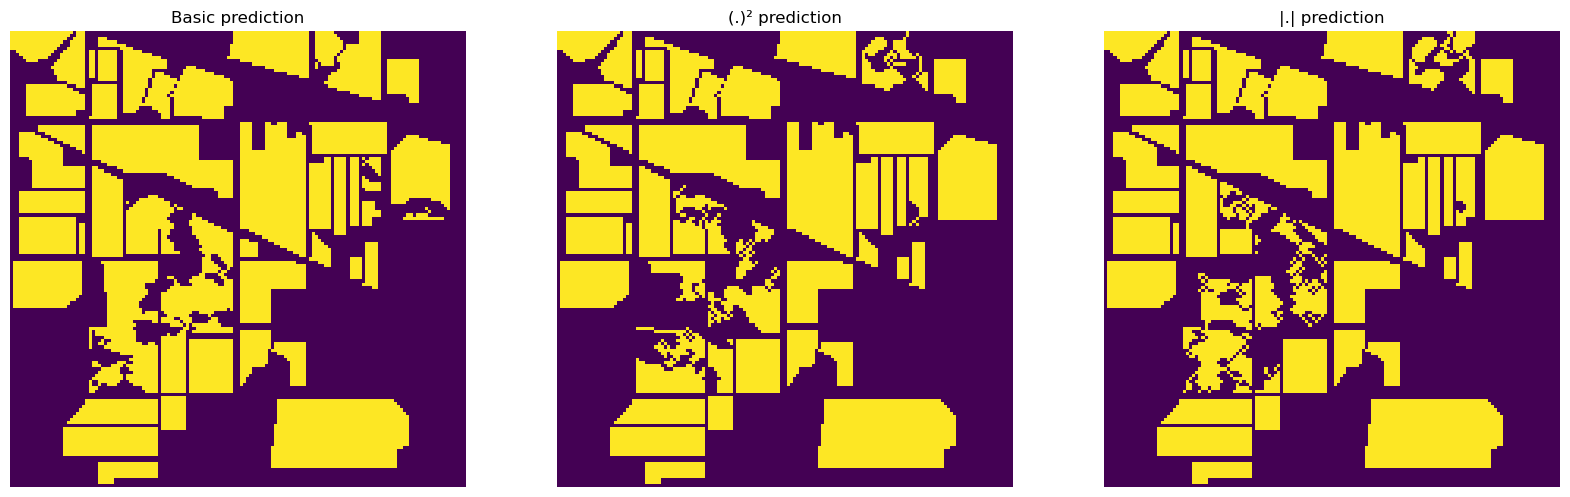

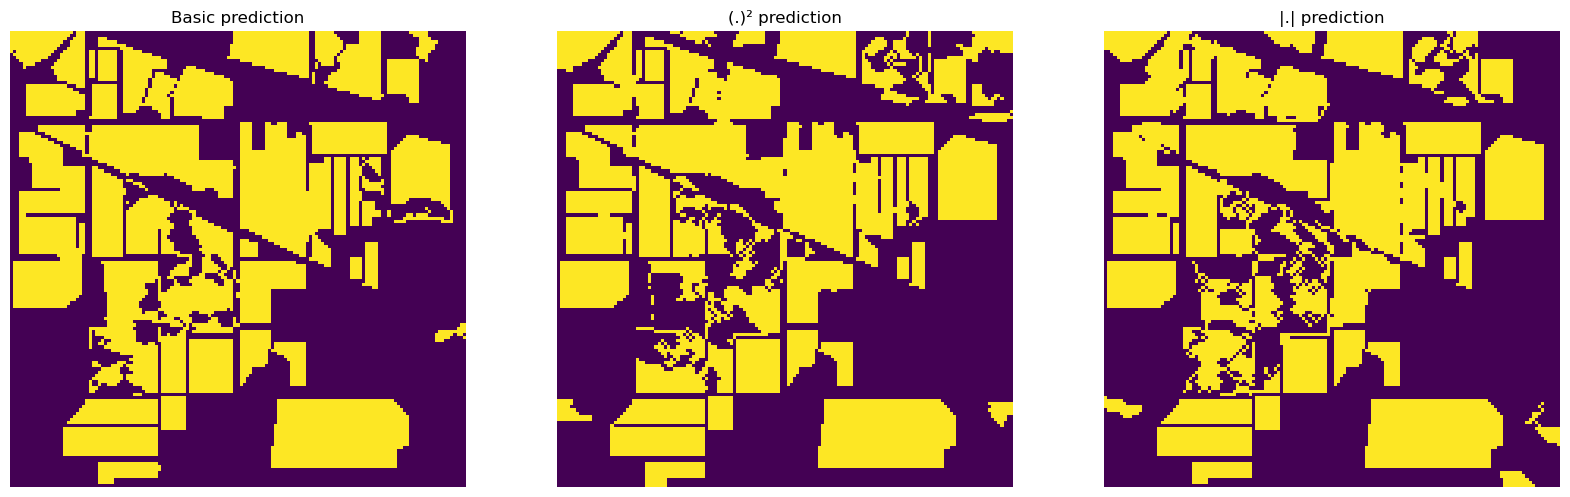

False


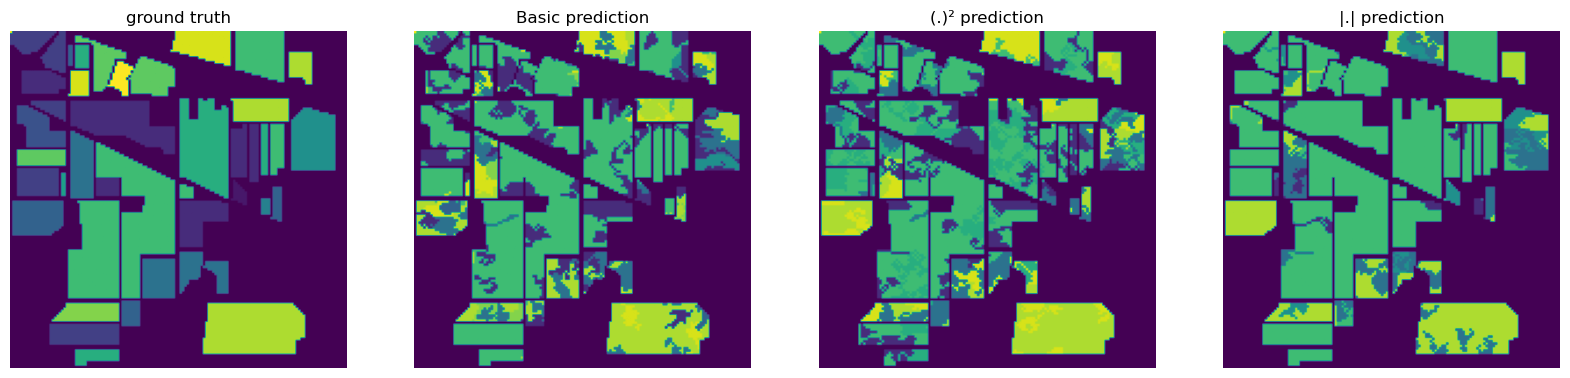

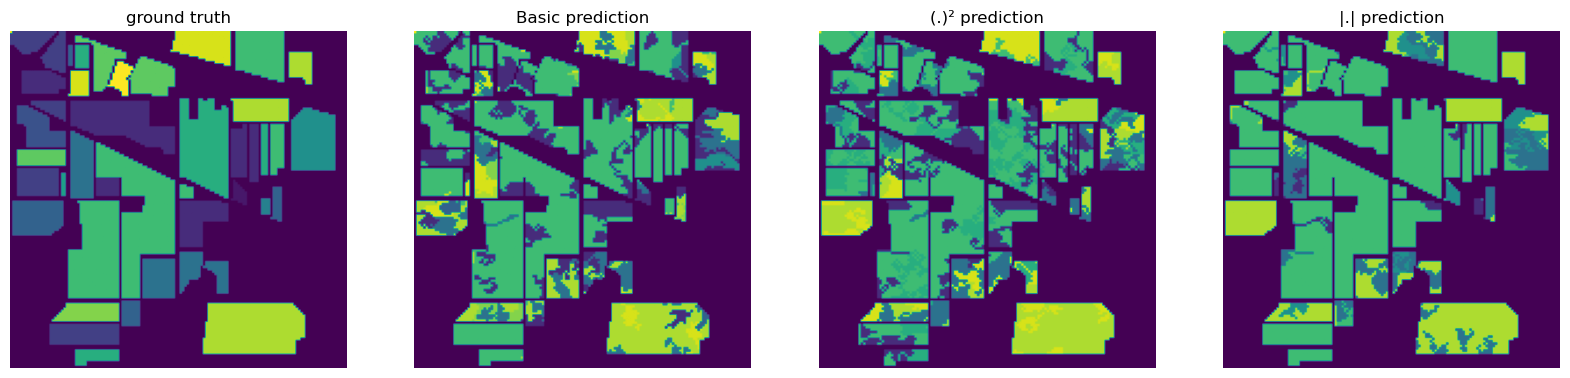

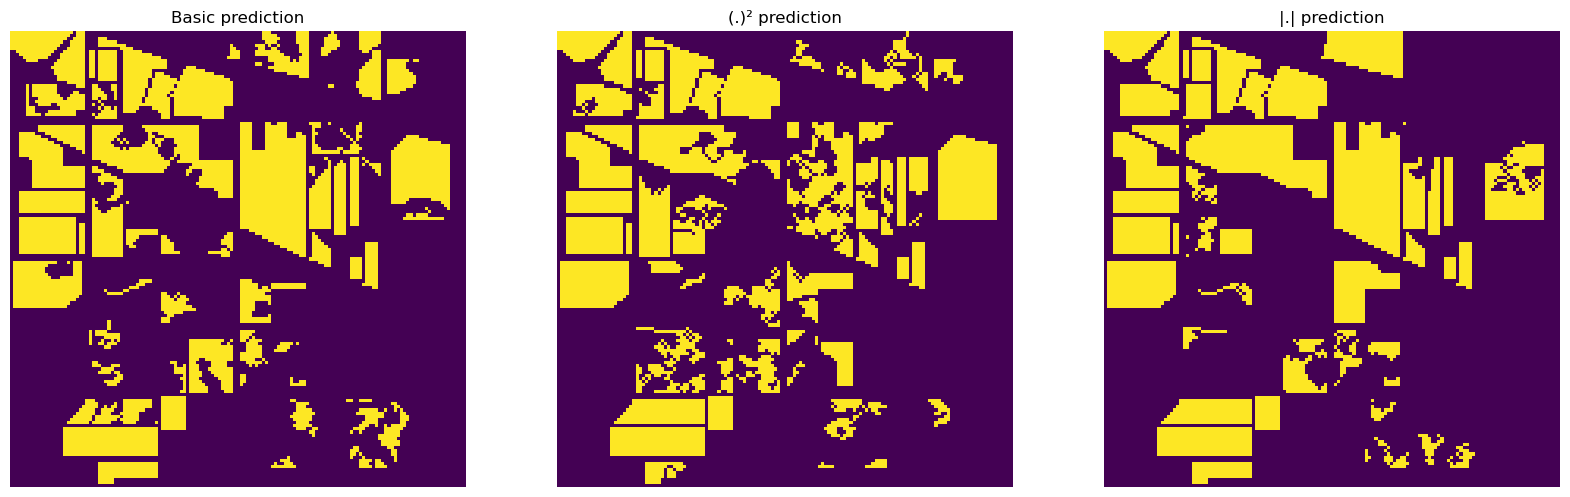

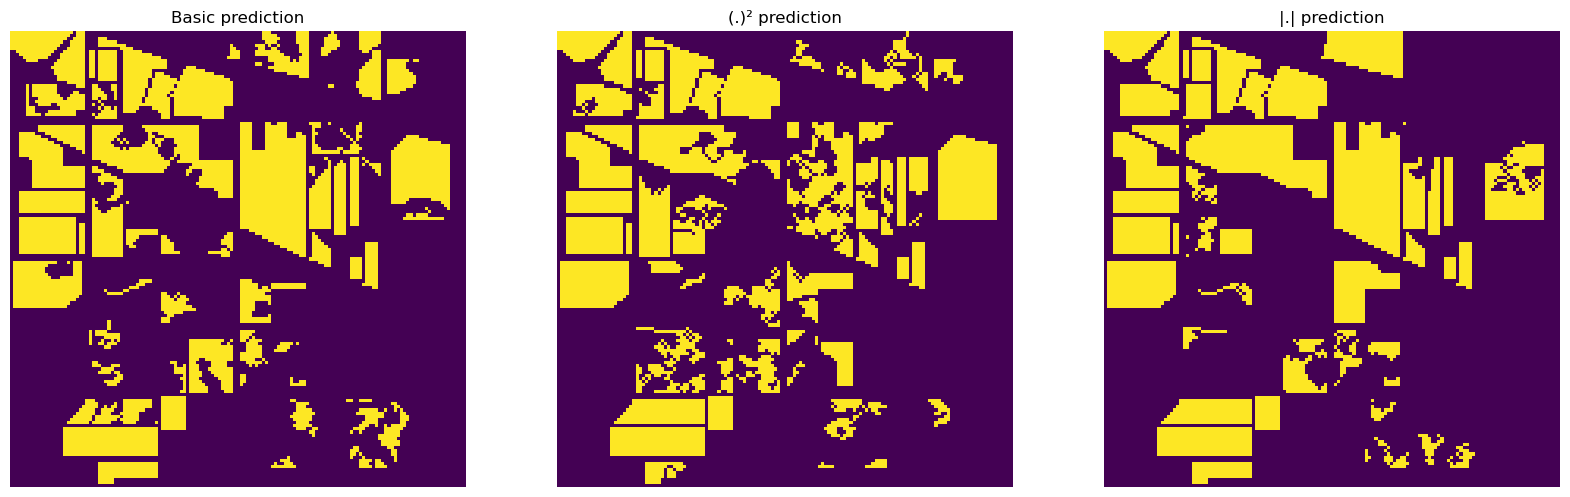

In [48]:
K = 500

fig, axs = plt.subplots(1, len(SPsDic[K]))
fig.set_size_inches(20,30)
for i,SP in enumerate(SPsDic[K]):
    axs[i].imshow(usedDataset["gt"])
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], SP, color=[255,255,255,200]))
    axs[i].title.set_text(names[i])
    axs[i].axis("off")
plt.show()



for b in [True, False]:
    print(b)
    classifiers = ClassifierDic[b][K]

    imgs = [usedDataset["gt"]] + [C.guess_map for C in classifiers]
    titles = ["ground truth"] + [name+" prediction" for name in names]


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]==0:
                    new_img[x,y] = 0
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=0 and usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()

    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()


### Classification result

In [49]:
size = len(ClassifierDic[True][Ks[0]])
overallAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageWeigthedJaccard = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
singleClassCounts = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageProportions = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}

labelsAccuracy = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}
labelsJaccard = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}

for b in [True, False]:
    print(b)
    for K in Ks:
        for i,C in enumerate(ClassifierDic[b][K]):
            overallAccuracys[b][K][i] = C.overallAccuracy(usedDataset["gt"])
            averageAccuracys[b][K][i] = C.averageAccuracy(usedDataset["gt"])
            averageWeigthedJaccard[b][K][i] = C.averageWeightedJaccard(usedDataset["gt"], usedDataset["class"])
            singleClassCounts[b][K][i] = C.singleClassProportion()
            averageProportions[b][K][i] = C.averageProportion()
        
            for label in usedDataset["labels"]:
                if label in C.labels:
                    labelsAccuracy[b][label][K][i] = C.labelAccuracy(usedDataset["class"], label)
                    labelsJaccard[b][label][K][i] = C.jaccard(usedDataset["gt"], usedDataset["class"], label)
        

True
False


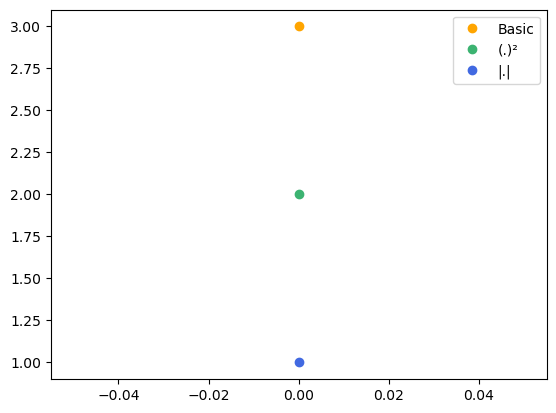

True


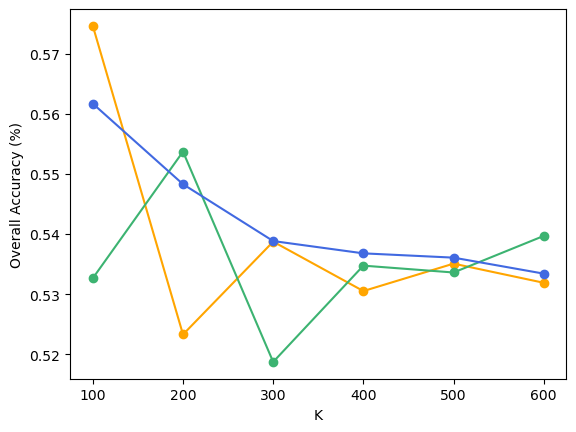

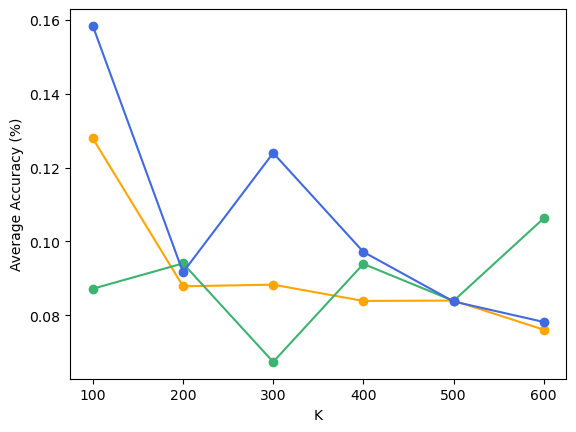

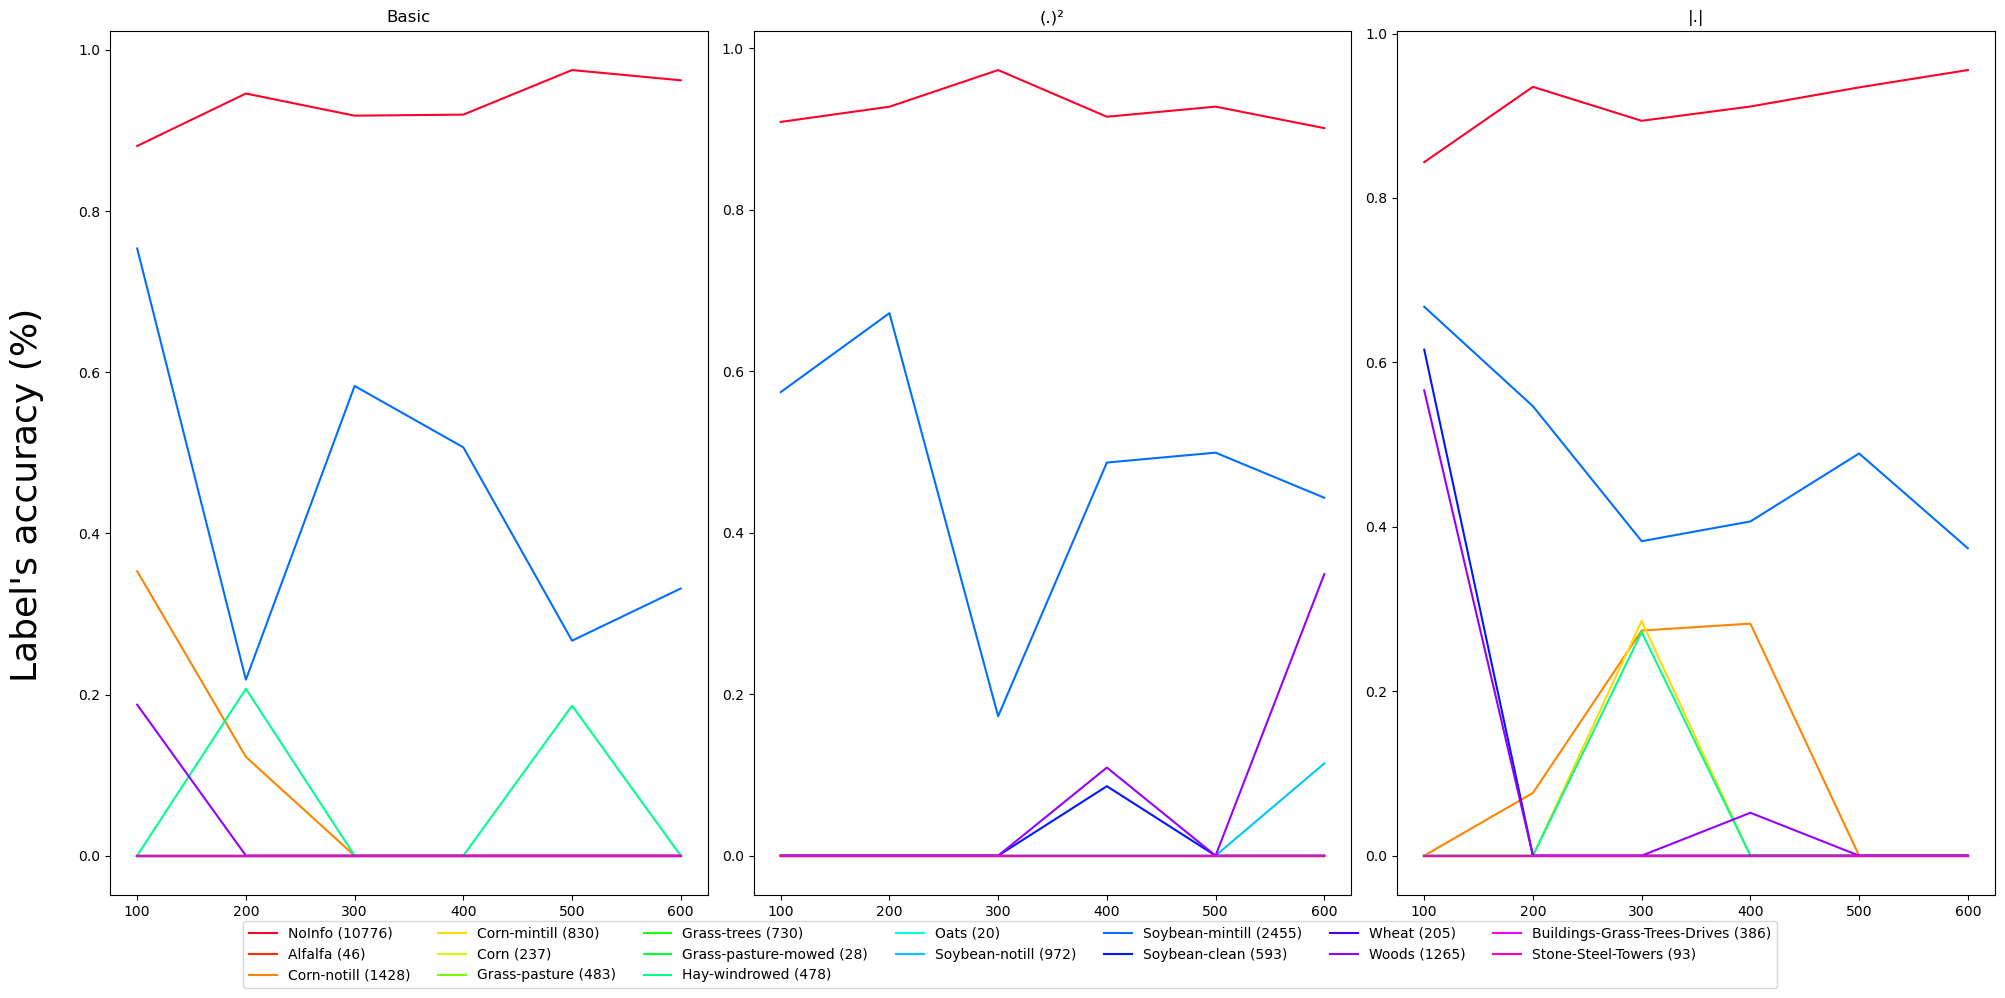

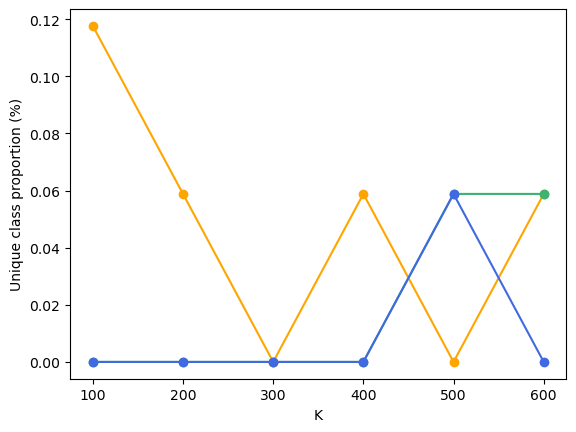

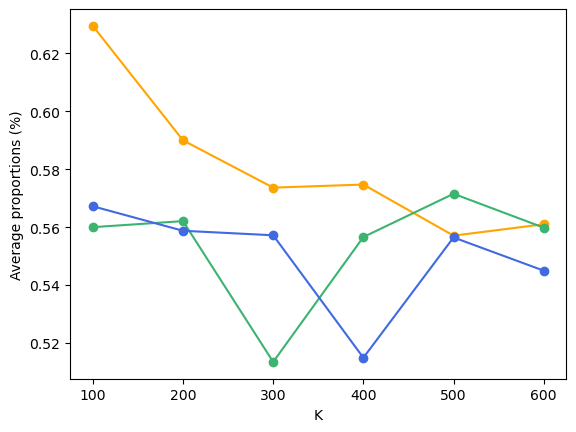

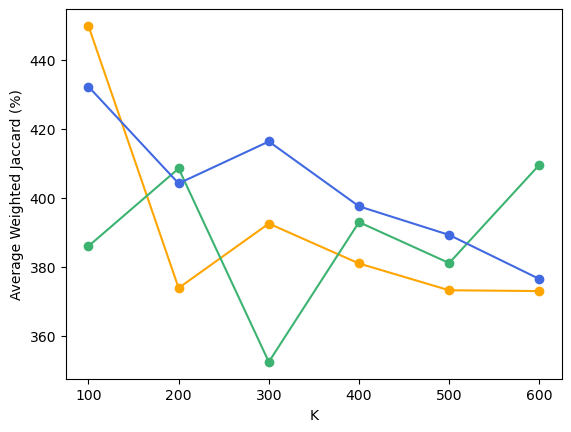

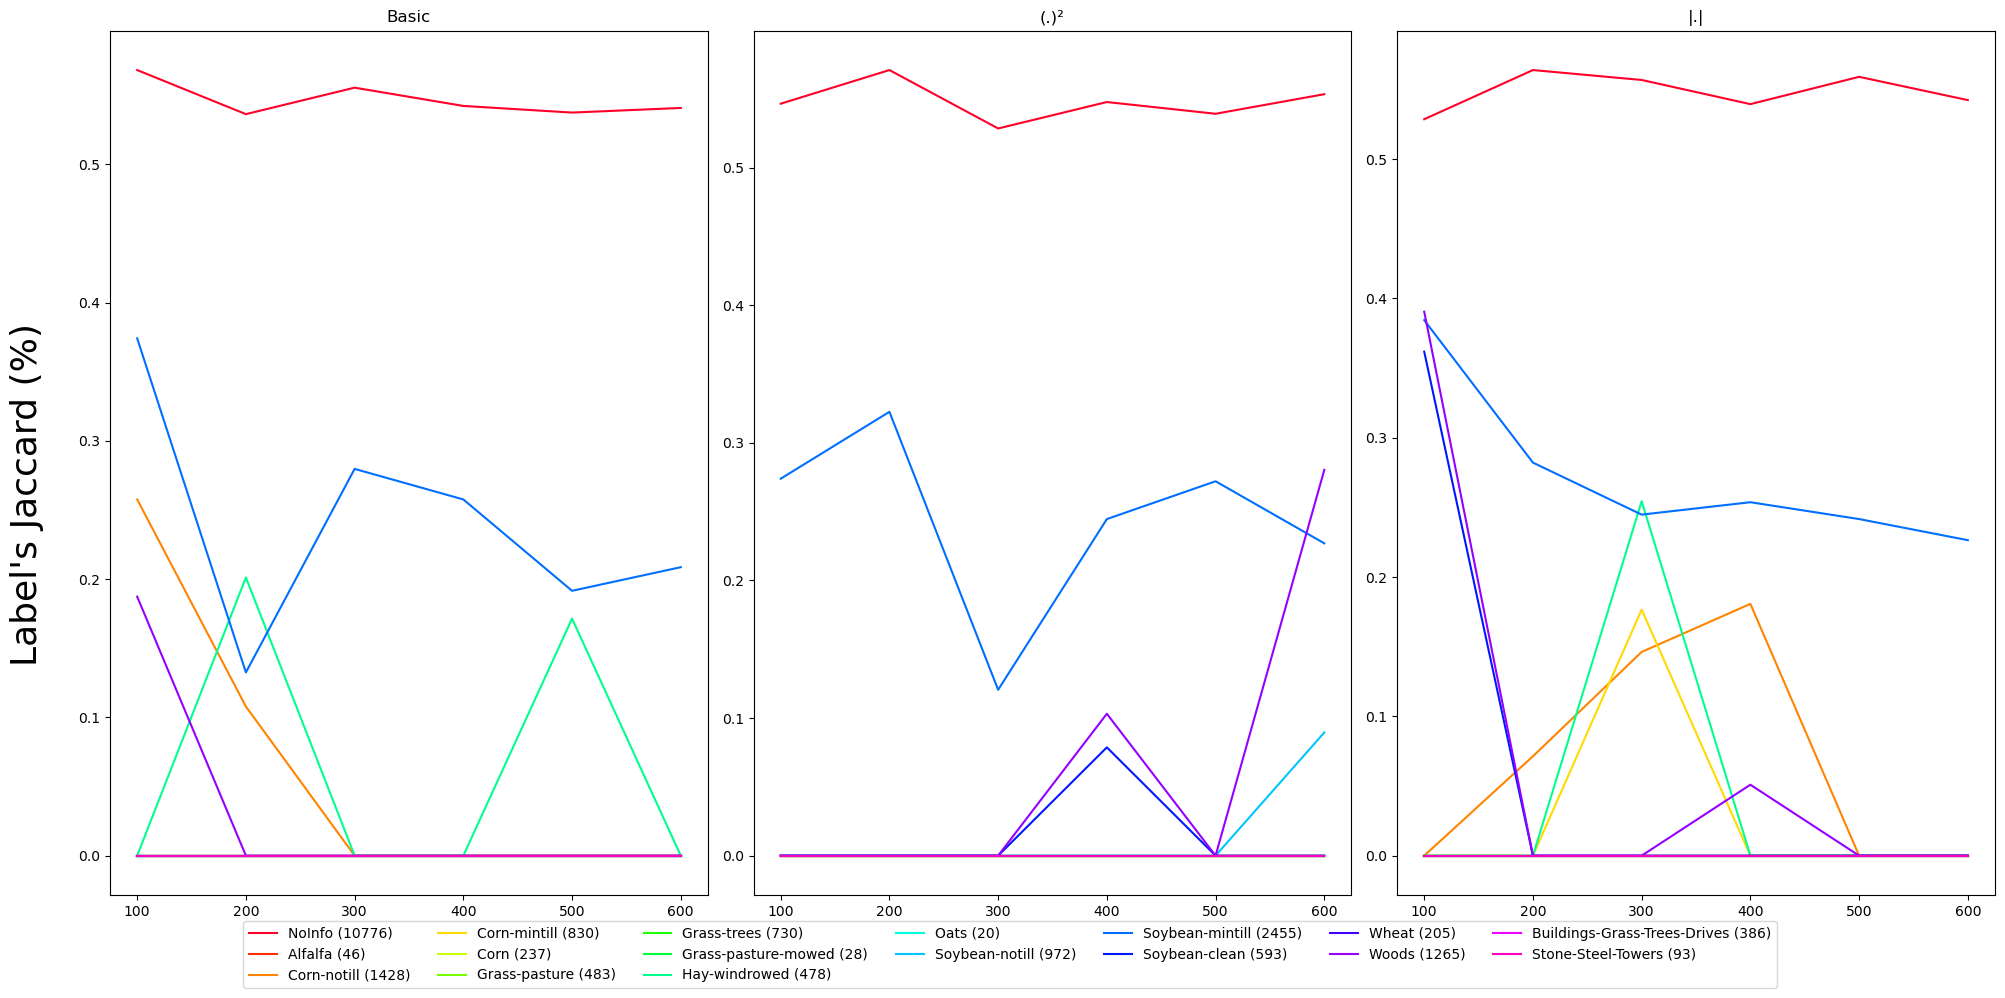

False


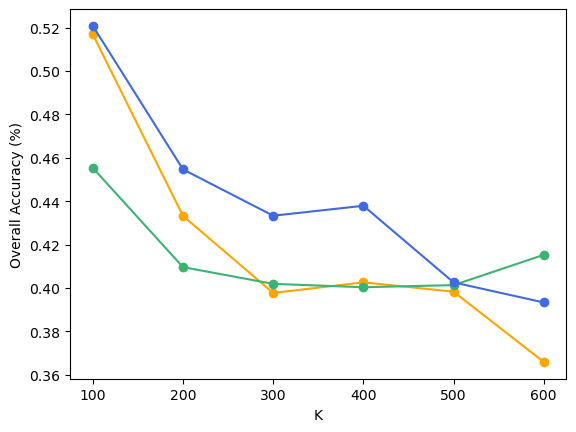

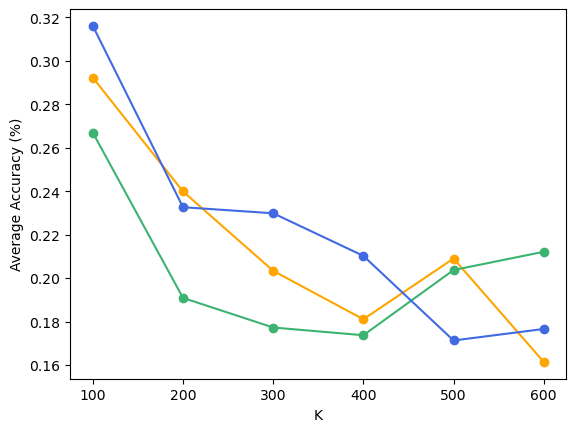

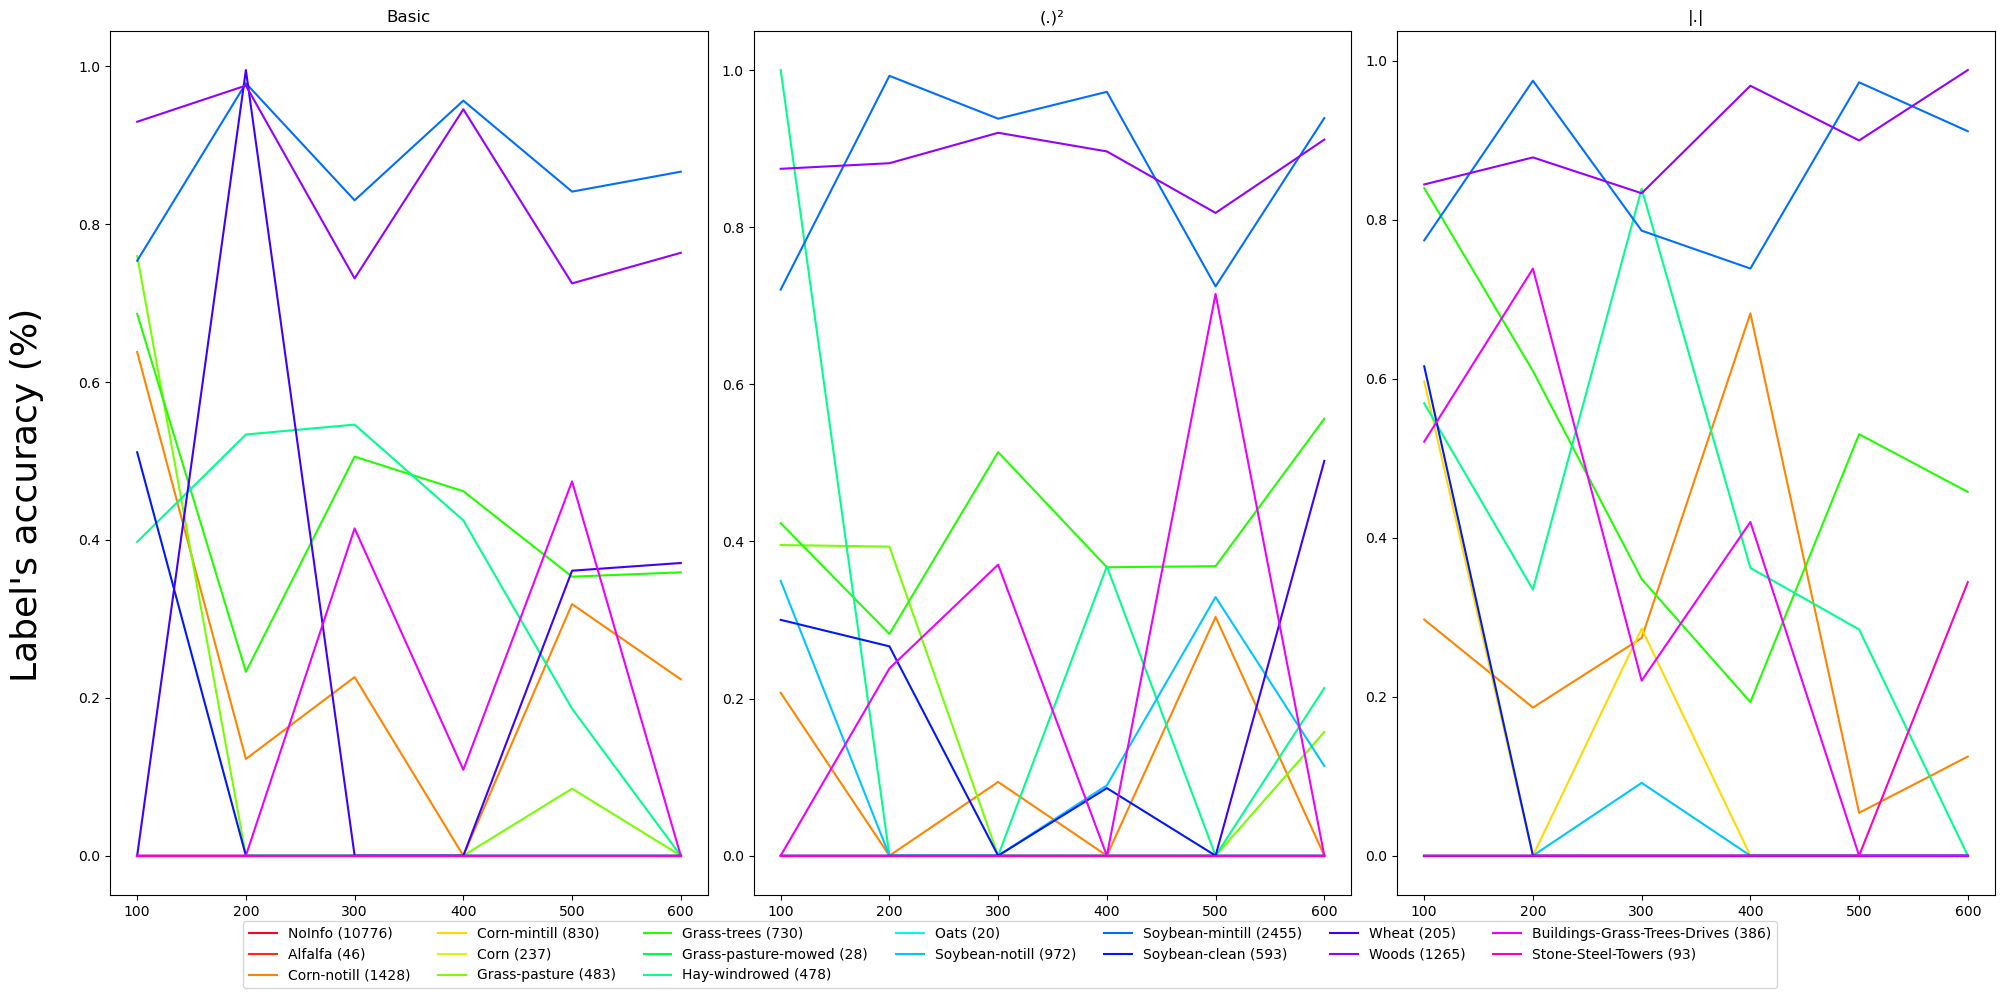

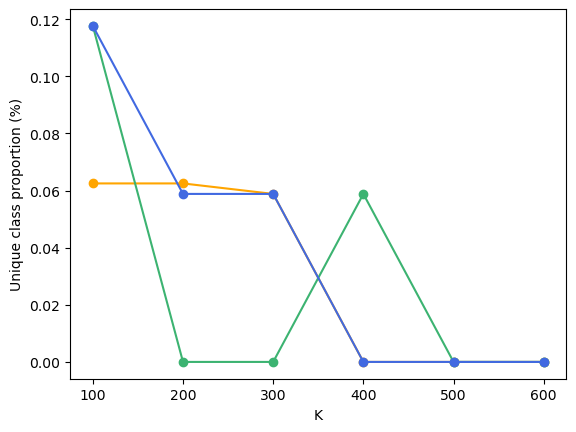

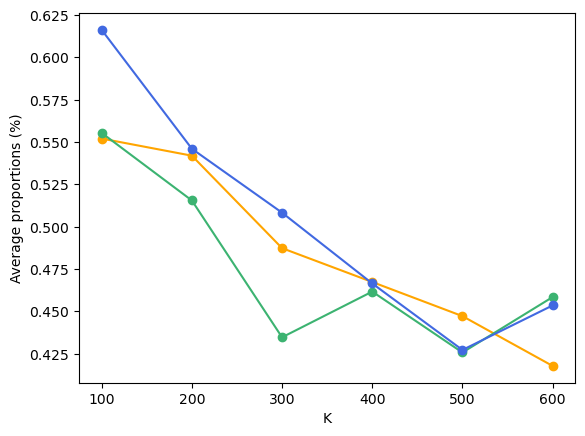

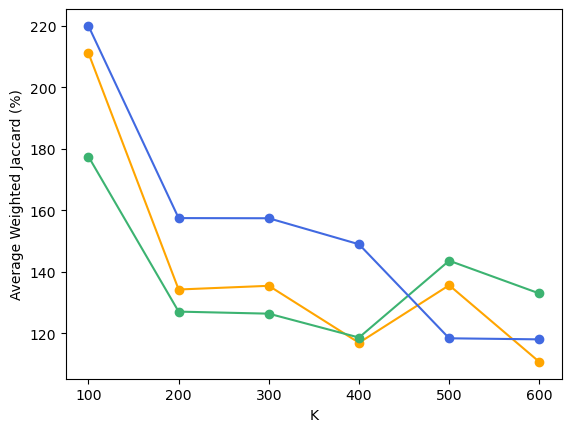

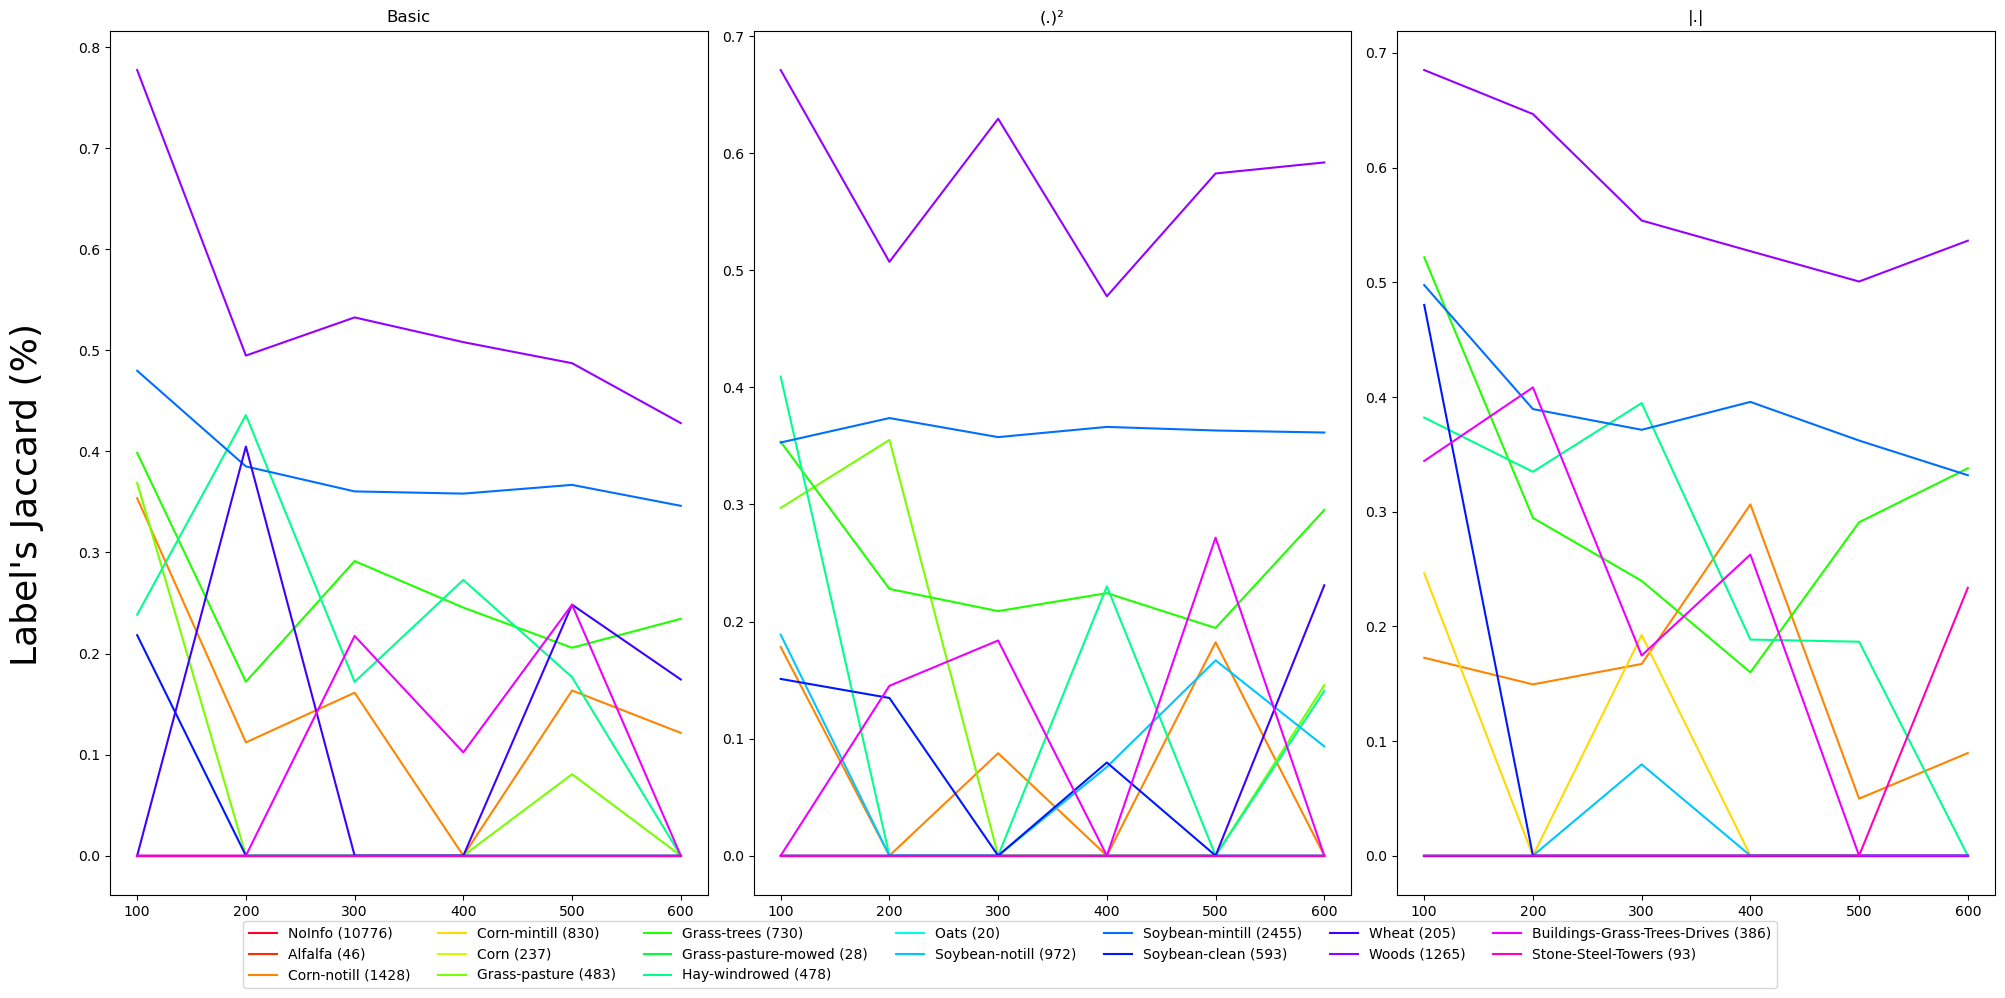

In [50]:
colors = ["orange", "mediumseagreen", "royalblue"]
def plot_info(info, ylabel="", plotbar=False):
    if plotbar:
        for k,K in enumerate(Ks):
            if K!=50:
                for d in range(size):
                    plt.bar(K+ d*20 -20, info[K][d], color=colors[d], width=20)
    else:
        length = len(info[Ks[0]])
        for i in range(length):
            plt.plot(Ks, [info[K][i] for K in Ks], "-o", color=colors[i])
            
    plt.xlabel("K")
    plt.ylabel(ylabel)
    plt.show()


def plot_label_info(info, ylabel=""):
    fig, axs = plt.subplots(1, len(datas), figsize=(20,10), sharex=True)
    for i in range(len(datas)):
        for label in usedDataset["labels"]:
            if label in info.keys():
                axs[i].plot(Ks, [info[label][K][i] for K in Ks], "-",
                            color=labels_color[label],
                            label=usedDataset["class"][label][0]+" ("+str(len(usedDataset["class"][label][1]))+")")
        axs[i].title.set_text(names[i])
    
    fig.text(0.0, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.0))

    plt.tight_layout()
    plt.subplots_adjust(left=0.05)  
    plt.subplots_adjust(bottom=0.10)
    plt.show()



for i in range(len(datas)):
    plt.plot(0,len(datas)-i,"o", color=colors[i], label=names[i])
plt.legend()
plt.show()


plotBar = False
motifs = ["-o", "--s", ":^"]
cmap = mpl.colormaps["gist_rainbow"]
labels_color = cmap(np.linspace(0, 1, len(usedDataset["labels"])))
for b in [True, False]:
    print(b)
    plot_info(overallAccuracys[b], "Overall Accuracy (%)", plotbar=plotBar)
    plot_info(averageAccuracys[b], "Average Accuracy (%)", plotbar=plotBar)
    plot_label_info(labelsAccuracy[b], "Label's accuracy (%)")
    plot_info(singleClassCounts[b], "Unique class proportion (%)", plotbar=plotBar)
    plot_info(averageProportions[b], "Average proportions (%)", plotbar=plotBar)
    plot_info(averageWeigthedJaccard[b], "Average Weighted Jaccard (%)", plotbar=plotBar)
    plot_label_info(labelsJaccard[b], "Label's Jaccard (%)")

### GA result

In [51]:
import sklearn.utils
from sklearn.preprocessing import StandardScaler

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1

            np.random.shuffle(indices)

            weights[key] = nb_info/ len(liste)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    


from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def SVM_accuracy(X_train,y_train, X_test,y_test):
    pipeline = Pipeline([
        ('scalar', StandardScaler()),
        ('svc', svm.SVC(kernel='rbf'))
    ])

    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]
    }

    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]]) /len(y_pred)


In [52]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

pourcents = {
    Data.IndianPines["name"]: 0.05,
    Data.PaviaUniversity["name"]: 0.02,
    Data.PaviaCenter["name"]: 0.01
}

best_fitness = {K:[0 for _ in range(len(datas))] for K in Ks}
best_accuracy = {K:[0 for _ in range(len(datas))] for K in Ks}

trainingData = usedDataset["data"]

S_list = {K:[SSGA.compute_Sbsp_Stsp_list(trainData, SPsDic[K][i]) for i in range(len(datas))] for K in Ks}
A = 5
for K in Ks:
    print("K:", K)
    for i in range(len(datas)):
        for a in range(A):
            print(a, end=" ")
            pop, fitness = SSGA.SSGA(trainingData, 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2,
                                SP=SPsDic[K][i], S_list=S_list[K][i])
            best_fitness[K][i] += fitness[0]

            bands = pop[0]
            X_train,y_train, X_test,y_test, weights = split_data(usedDataset, pourcents[usedDataset["name"]], bands)
            best_accuracy[K][i] += SVM_accuracy(X_train,y_train, X_test,y_test)

        best_fitness[K][i] /= A
        best_accuracy[K][i] /= A
        print()

K: 100
0 1 2 3 4 
0 1 2 3 4 
0 1 2 3 4 
K: 200
0 1 2 3 4 
0 1 2 3 4 
0 1 2 3 4 
K: 300
0 1 2 3 4 
0 1 2 3 

KeyboardInterrupt: 

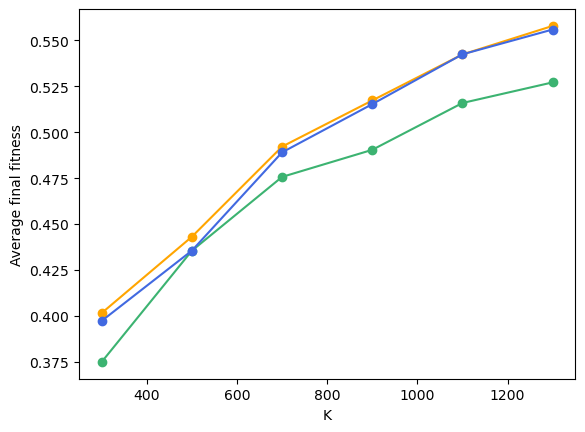

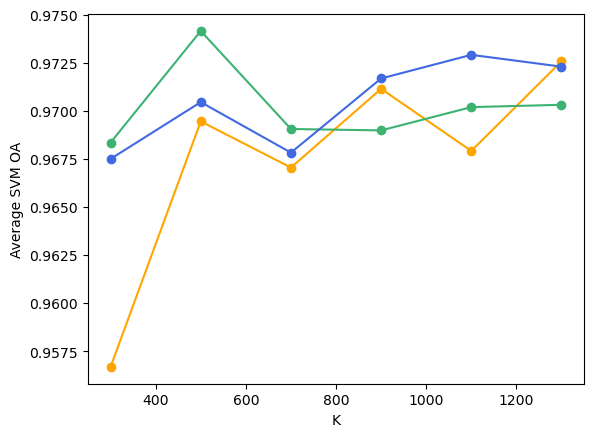

K = 300
[0.9566775977147065, 0.9683426849471969, 0.9674931993427736]
K = 500
[0.9694471525869768, 0.9741500030679656, 0.970447991164259]
K = 700
[0.9670445945853816, 0.9690503623608336, 0.9678204490138194]
K = 900
[0.9711393060943434, 0.9689767311848483, 0.971677904511273]
K = 1100
[0.9679090791330612, 0.9701875549677181, 0.9729064543179913]
K = 1300
[0.9725723869454652, 0.9703089100540643, 0.9722914976444841]


In [ ]:
plot_info(best_fitness, "Average final fitness")
plot_info(best_accuracy, "Average SVM OA")
for K in Ks:
    print("K =", K)
    print(best_accuracy[K])